# Cross-Cryptocurrency Predictive Model: 
## Using the historical price of Bitcoin and Ethereum to predict the price direction for Ethereum
- Harsh Patel & Alec Slim
- COGS 118B - Prof. de Sa 

This project aims to predict the daily movement of Ethereum prices based on historical data of Bitcoin and Ethereum. The workflow includes data preprocessing, feature engineering, model training, evaluation, and comparison of various machine learning models. The models used in this project include Random Forest, Gradient Boosting, Logistic Regression, and Support Vector Machine (SVM). The performance of these models is evaluated using metrics such as accuracy, precision, confusion matrix, ROC curve, and precision-recall curve. The results are visualized to compare the effectiveness of each model in predicting Ethereum price movements.

## Data Preprocessing
- #### Importing Necessary Libraries
    This cell imports all the necessary libraries required for data manipulation, visualization, model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import joblib

- #### Load the Bitcoin and Ethereum Datasets
    Loads the Bitcoin and Ethereum datasets from CSV files.

In [2]:
# Load the new Bitcoin and Ethereum datasets
bitcoin_data = pd.read_csv('BTC_data_2024-2016.csv')
ethereum_data = pd.read_csv('ETH_data_2024-2016.csv')

- #### Clean and Convert Columns
    - Converts the 'Date' column to datetime format.
    - Cleans and converts the numerical columns 'Price', 'Open', 'High', and 'Low' from string to float.
    - Converts the 'Vol.' columns to numerical values by handling 'K', 'M', and 'B' suffixes.
    - Cleans the 'Change %' column by removing the '%' sign and converting it to float.

In [3]:
# Convert 'Date' to datetime
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
ethereum_data['Date'] = pd.to_datetime(ethereum_data['Date'])

# Clean and convert numerical columns
for col in ['Price', 'Open', 'High', 'Low']:
    bitcoin_data[col] = bitcoin_data[col].str.replace(',', '').astype(float)
    ethereum_data[col] = ethereum_data[col].str.replace(',', '').astype(float)

# Convert 'Vol.' columns to numerical values by handling 'K', 'M', and 'B'
def convert_volume(vol):
    if isinstance(vol, str):
        if 'K' in vol:
            return float(vol.replace('K', '').replace(',', '')) * 1e3
        elif 'M' in vol:
            return float(vol.replace('M', '').replace(',', '')) * 1e6
        elif 'B' in vol:
            return float(vol.replace('B', '').replace(',', '')) * 1e9
    return float(vol)

bitcoin_data['Vol.'] = bitcoin_data['Vol.'].apply(convert_volume)
ethereum_data['Vol.'] = ethereum_data['Vol.'].apply(convert_volume)

# Clean 'Change %' column and convert to float
bitcoin_data['Change %'] = bitcoin_data['Change %'].str.replace('%', '').astype(float)
ethereum_data['Change %'] = ethereum_data['Change %'].str.replace('%', '').astype(float)


- #### Calculate Ethereum Daily Movement & Merge Datasets
    - cell will calculates the daily movement of Ethereum prices and adds it as a new column 'ETH_Movement'.
    - cell will also merges the Bitcoin and Ethereum datasets on the 'Date' column and renames Ethereum's 'Price' column for clarity.


In [4]:
# Calculate Ethereum daily movement
ethereum_data['ETH_Movement'] = (ethereum_data['Price'].diff() > 0).astype(int)

# Merge datasets on 'Date'
data = pd.merge(bitcoin_data, ethereum_data[['Date', 'ETH_Movement', 'Price', 'Change %', 'Vol.']], on='Date', suffixes=('_BTC', '_ETH'))

# Rename Ethereum's Price for clarity
data.rename(columns={'Price_ETH': 'ETH_Price'}, inplace=True)

- #### Historical Bitcoin and Ethereum Price Data Visualization 
    Let's visualizes the Bitcoin and Ethereum prices over time and the correlation matrix of features.

Bitcoin and Ethereum Prices Over Time


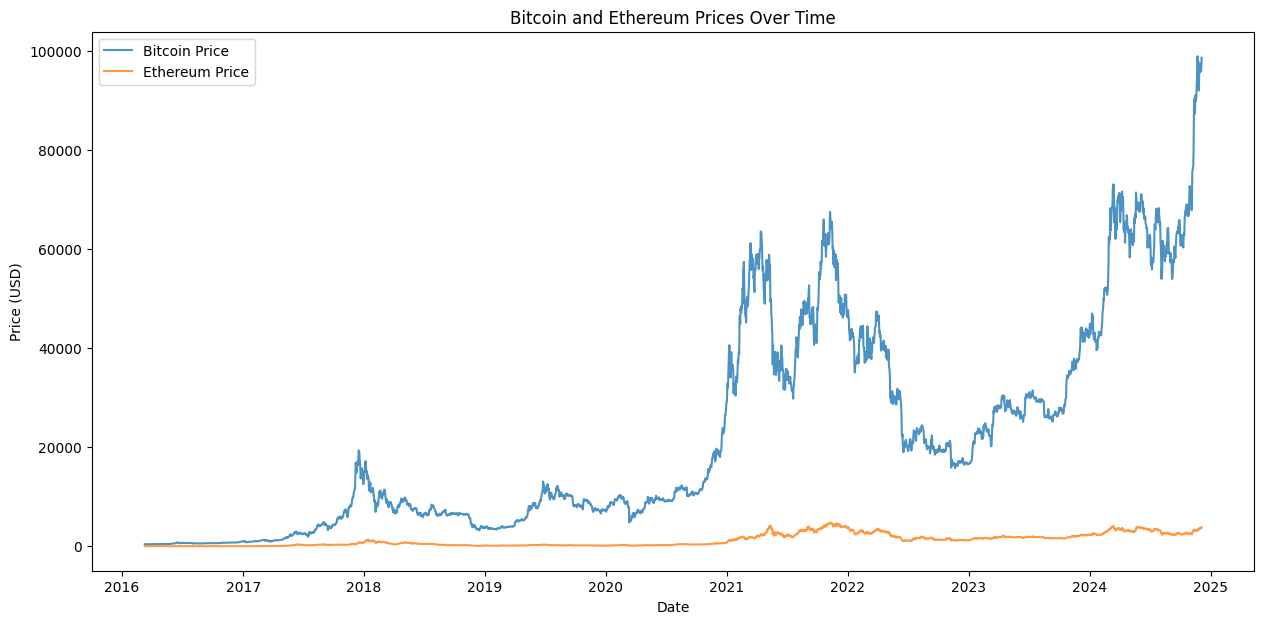

Correlation Matrix of Features


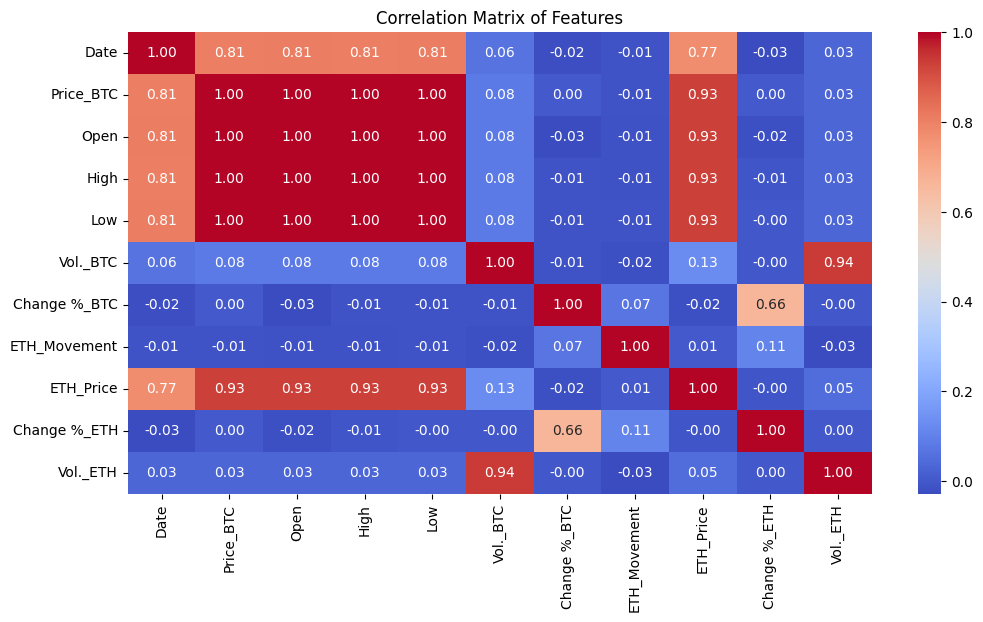

In [5]:
#Bitcoin and Ethereum Prices Over Time
print("Bitcoin and Ethereum Prices Over Time")
plt.figure(figsize=(15, 7))
plt.plot(data['Date'], data['Price_BTC'], label='Bitcoin Price', alpha=0.8)
plt.plot(data['Date'], data['ETH_Price'], label='Ethereum Price', alpha=0.8)
plt.title('Bitcoin and Ethereum Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#Correlation Matrix of Features
print("Correlation Matrix of Features")
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

## Feature Engineering
- This section adds lag features, rolling averages, volatility, percentage change features, and interaction terms to the dataset. It will also add percentage change features for Bitcoin and Ethereum.


In [6]:
# Add lag features, rolling averages, and volatility
data['Bitcoin_Lag1'] = data['Price_BTC'].shift(1)
data['Bitcoin_Lag2'] = data['Price_BTC'].shift(2)
data['Ethereum_Lag1'] = data['ETH_Price'].shift(1)
data['Ethereum_Lag2'] = data['ETH_Price'].shift(2)
data['Bitcoin_Rolling_Avg'] = data['Price_BTC'].rolling(window=5).mean()
data['Ethereum_Rolling_Avg'] = data['ETH_Price'].rolling(window=5).mean()
data['Bitcoin_Volatility'] = data['Price_BTC'].rolling(window=5).std()
data['Ethereum_Volatility'] = data['ETH_Price'].rolling(window=5).std()

# Add percentage change features
data['Bitcoin_Change'] = data['Change %_BTC']
data['Ethereum_Change'] = data['Change %_ETH']

- #### Visualize Percentage Changes & Add Interaction Terms
    The cell visualizes the percentage changes of Bitcoin and Ethereum over time. It will also add interaction terms between Bitcoin and Ethereum lag features using polynomial features. It will also drop rows with NaN values created by lagging and rolling operations

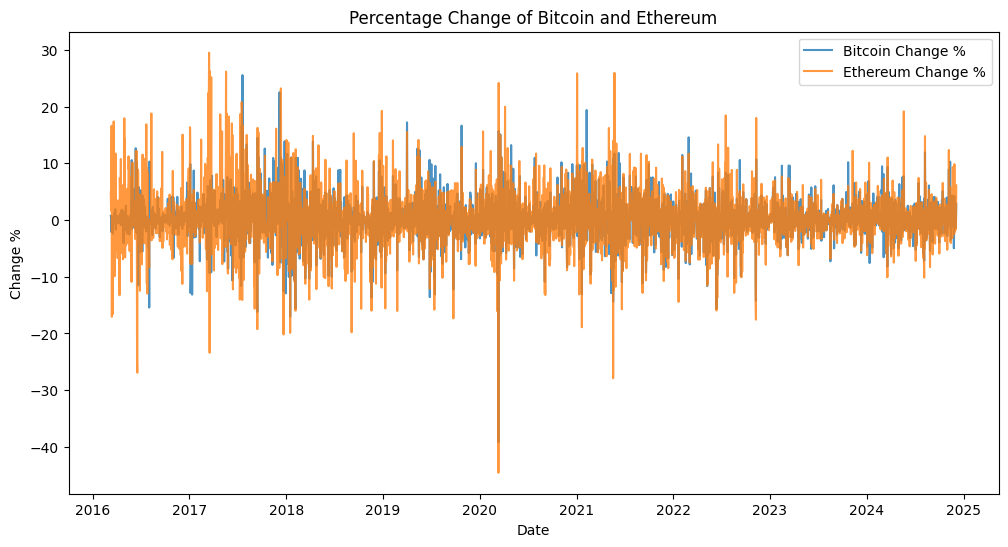

In [7]:
# Visualize percentage changes
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Bitcoin_Change'], label='Bitcoin Change %', alpha=0.8)
plt.plot(data['Date'], data['Ethereum_Change'], label='Ethereum Change %', alpha=0.8)
plt.title('Percentage Change of Bitcoin and Ethereum')
plt.xlabel('Date')
plt.ylabel('Change %')
plt.legend()
plt.show()

# Add interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_terms = poly.fit_transform(data[['Bitcoin_Lag1', 'Ethereum_Lag1']].dropna())
interaction_df = pd.DataFrame(interaction_terms, columns=[f'interaction_{i}' for i in range(interaction_terms.shape[1])])
data = pd.concat([data.reset_index(drop=True), interaction_df], axis=1)

# Drop rows with NaN values created by lagging and rolling operations
data.dropna(inplace=True)

## Model Training
- This section will select features and target variables, splits the data into training and testing sets, standardizes the features, trains multiple models (Random Forest, Gradient Boosting, Logistic Regression, and SVM), and evaluates their performance using accuracy, precision, confusion matrix, ROC curve, and Precision-Recall curve.

In [8]:
# Select features and target
features = ['Bitcoin_Lag1', 'Bitcoin_Lag2', 'Ethereum_Lag1', 'Ethereum_Lag2', 'Bitcoin_Change', 'Ethereum_Change',
            'Bitcoin_Rolling_Avg', 'Ethereum_Rolling_Avg', 'Bitcoin_Volatility', 'Ethereum_Volatility'] + list(interaction_df.columns)
X = data[features]
y = data['ETH_Movement']

# Binarize the target variable for ROC and PR curves
y_binarized = label_binarize(y, classes=[0, 1])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for Logistic Regression and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- ##### Train and evaluate models

Training Random Forest...


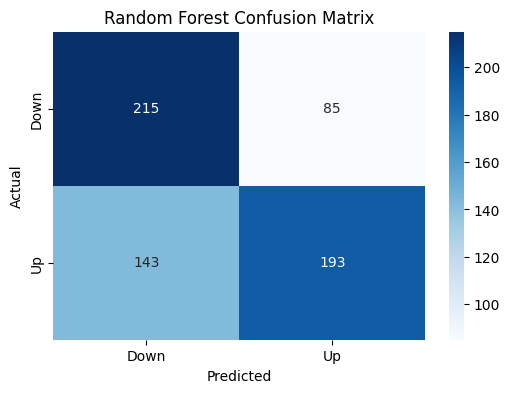

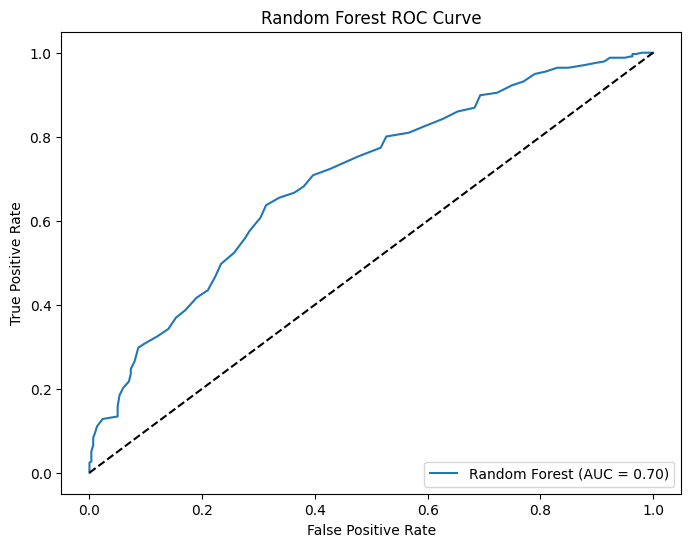

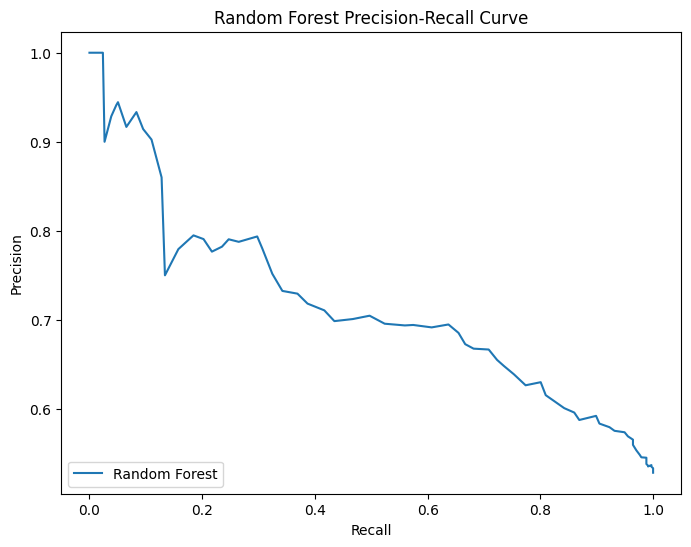

Random Forest Accuracy: 0.64
Random Forest Precision: 0.65
Training Gradient Boosting...


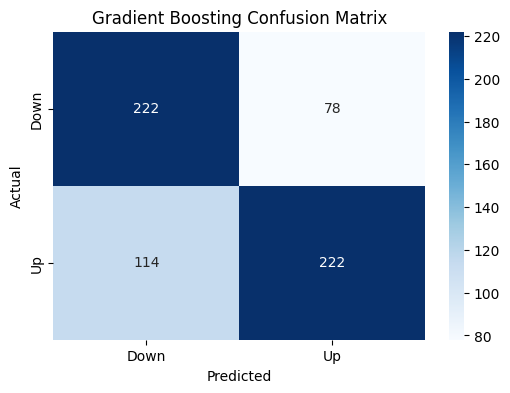

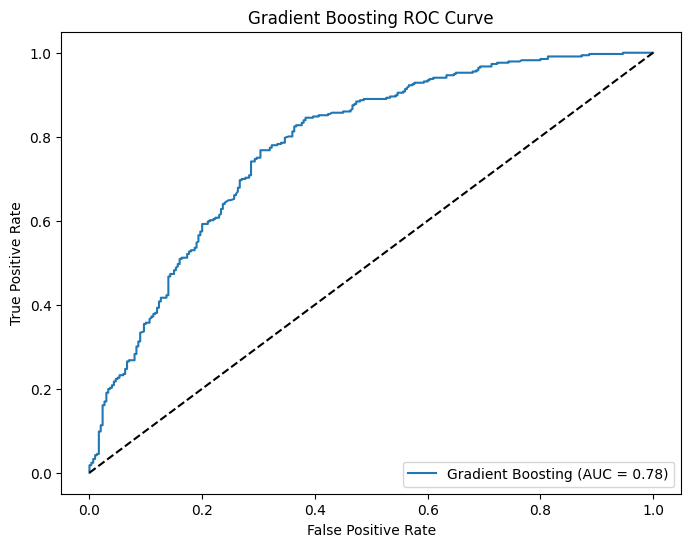

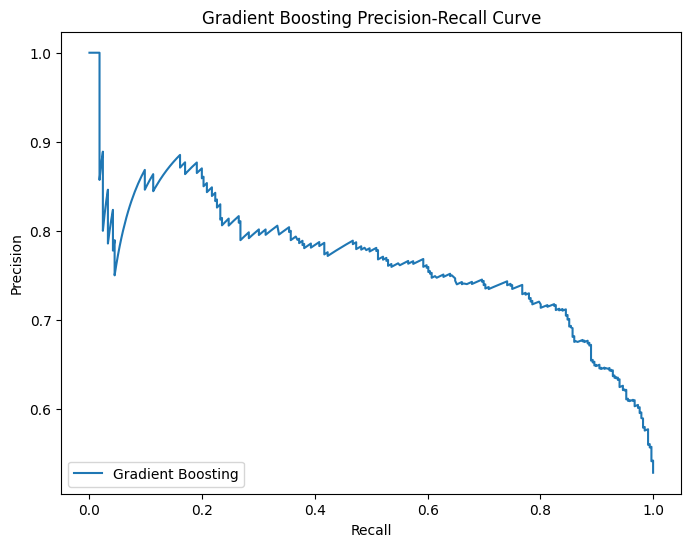

Gradient Boosting Accuracy: 0.70
Gradient Boosting Precision: 0.70
Training Logistic Regression...


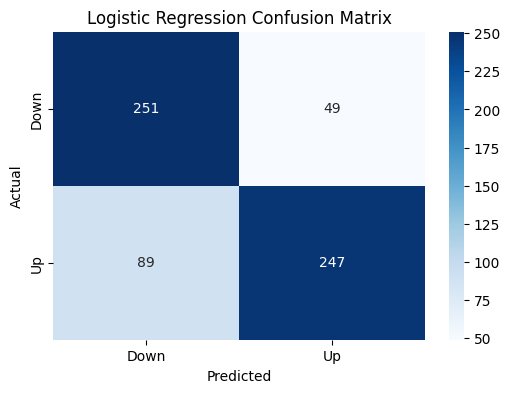

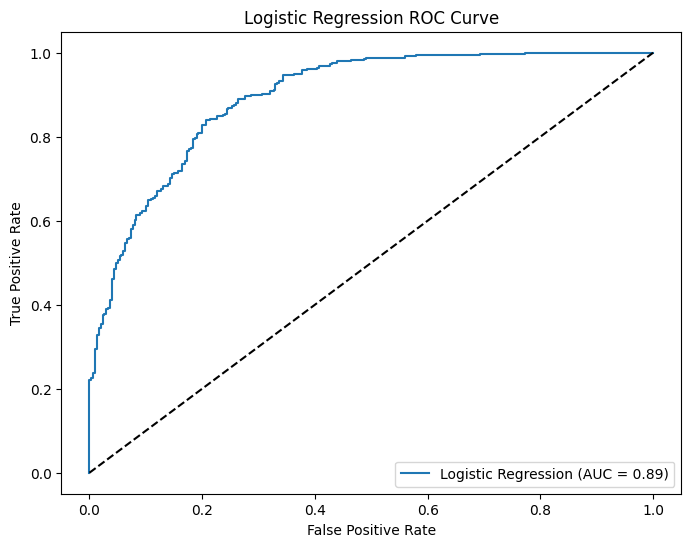

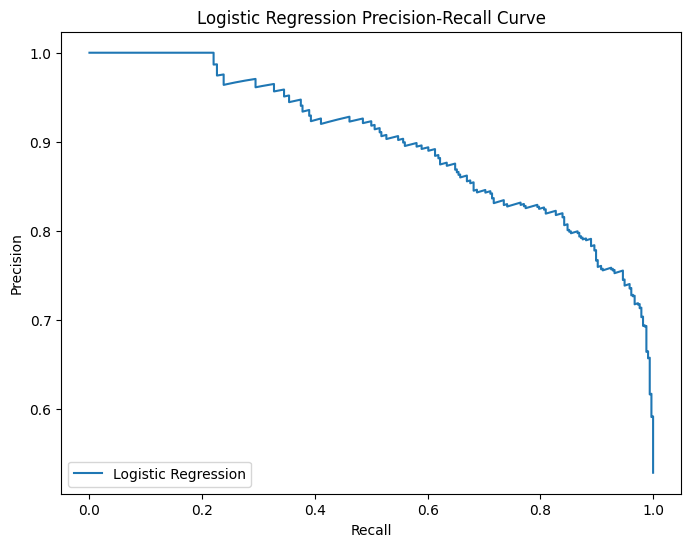

Logistic Regression Accuracy: 0.78
Logistic Regression Precision: 0.79
Training SVM...


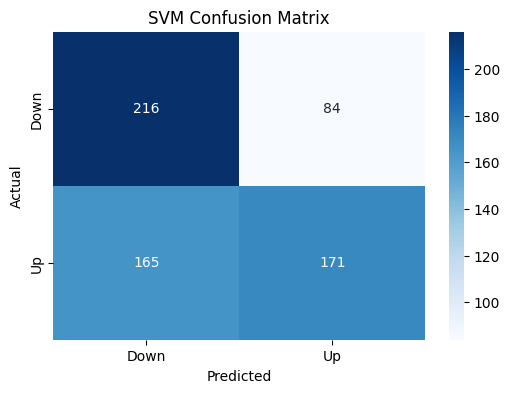

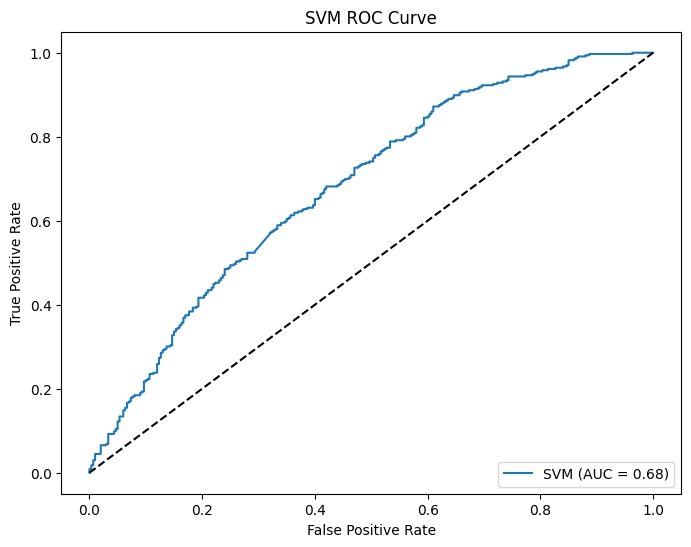

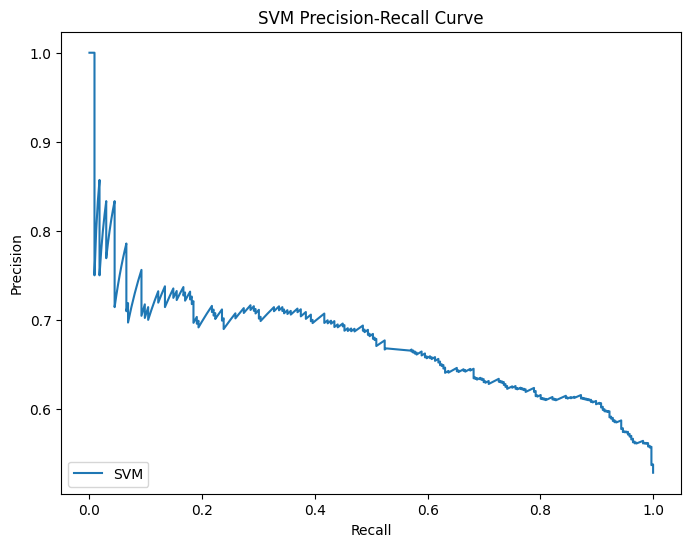

SVM Accuracy: 0.61
SVM Precision: 0.62


In [9]:

# Train and evaluate models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision']
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': cm
    }

    # Individual Model Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f'{name}')
    plt.title(f'{name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

    print(f"{name} Accuracy: {accuracy:.2f}")
    print(f"{name} Precision: {precision:.2f}")

## Model Comparison
Now Let's compare all the model we trained above:
- #### Comparison of Model Accuracy
    This cell visualizes the accuracy of different machine learning models by creating a bar chart that compares the accuracy of each model.

Model Accuracy Comparison


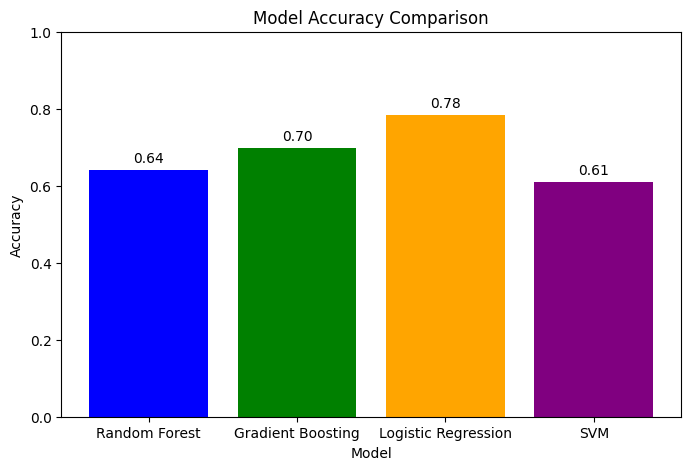

In [10]:
# Visualize model accuracy
print("Model Accuracy Comparison")
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=10)
plt.show()

- #### Comparison of Model Precision
    This cell visualizes the precision of different machine learning models by creating a bar chart that compares the precision of each model.

Model Precision Comparison


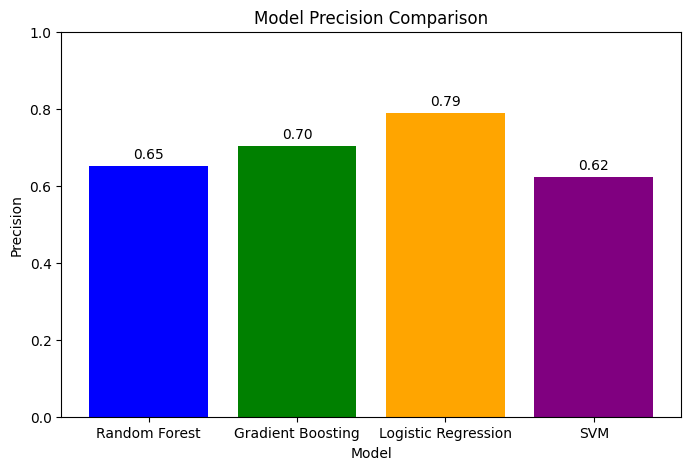

In [11]:
# Visualize model precision
print("Model Precision Comparison")
precisions = [results[name]['precision'] for name in model_names]

plt.figure(figsize=(8, 5))
plt.bar(model_names, precisions, color=['blue', 'green', 'orange', 'purple'])
plt.title('Model Precision Comparison')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.ylim(0, 1)
for i, prec in enumerate(precisions):
    plt.text(i, prec + 0.02, f"{prec:.2f}", ha='center', fontsize=10)
plt.show()

- #### ROC Curve Comparison
    This cell visualizes the ROC curves of different machine learning models by plotting the False Positive Rate against the True Positive Rate for each model, and compares their AUC (Area Under the Curve) values.

ROC Curve Comparison


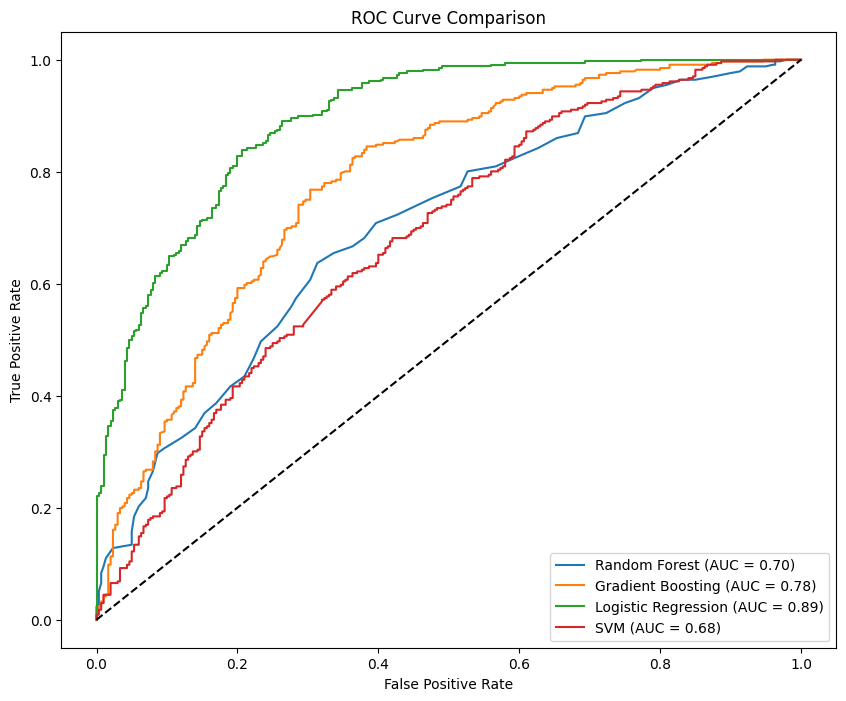

In [12]:
# ROC Curve Comparison
print("ROC Curve Comparison")
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name in ['Logistic Regression', 'SVM']:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Save Results
This cell saves the results of the model comparisons, including accuracy and precision metrics, to a file using the `joblib` library.

In [13]:
# Save results
joblib.dump(results, 'model_comparison_results.pkl')

['model_comparison_results.pkl']